Victorian Property offence Investigation

Research Question: Monitoring criminal activity is important to maintain a functioning society. Of the types of criminal activity, property offences make up the large majority. As a result I believe that an investigation into this field is not only beneficial but necessary in order to help promote a safer community. To address this topic, I believe that the correlation between criminal activity and the place of occurence needs to be investigated in order to allow the police to control criminal activity efficiently. The following questions carry forward this investigation
Where and what type of property damage is most likely to occur in certain areas? Should certain areas be prioritised with certain services (fire station, police station)? Considering the large scale of Victorian crime, should property offence reduction be the focus of the police department?

In [15]:
# standard imports ....

#Needed to do basic dataframe manipulation
import pandas as pd
import numpy as np

#Needed to create graphs
import matplotlib.pyplot as plt

#Needed to scale varaibles
from sklearn.preprocessing import StandardScaler

#Needed to create a heatmap
from scipy.spatial.distance import pdist, squareform
import seaborn as sns


###keywords
#LGA == local government area
#ERP == Estimated Resident Population

In [16]:
#Functions Definitons borrowed with permission from phase 2
def my_entropy(probs):
    return -probs.dot(np.log2(probs))
def mutual_info(X,Y):
    
    df = pd.DataFrame.from_dict({'X' : X,  'Y' :Y})
    Hx = my_entropy(df.iloc[:,0].value_counts(normalize=True, sort=False))
    Hy = my_entropy(df.iloc[:,1].value_counts(normalize=True, sort=False))
    
    
    counts = df.groupby(["X","Y"]).size()
    probs = counts/ counts.values.sum()
    H_xy = my_entropy(probs)

    # Mutual Information
    I_xy = Hx + Hy - H_xy
    MI = I_xy
    NMI = I_xy/min(Hx,Hy)  
    return NMI

def VAT(R):
          
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))
        
    J = list(range(0, N))
    
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)


    I = i[j]
    del J[I]

    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    
    C = [1,1]
    for r in range(2, N-1):   
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)        
        y = np.min(y)      
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])
    
    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)
    
    I.extend(J)
    C.extend(i)
    
    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx

    RV = R[I,:][:,I]
    
    return RV.tolist(), C, I

In [17]:
#Imports the datasets to be used
crime_df =  pd.read_csv("Crime by location_1_Region_PSA_LGA_OffenceType - year ending June 2017.csv" ,low_memory=False, encoding = 'ISO-8859-1' )
property_df = pd.read_csv("Offence_Visualisation_4_Property_Offences_LocationType - year ending June 2017.csv" ,low_memory=False, encoding = 'ISO-8859-1' )
offence_rate_df = pd.read_csv("Offence_Visualisation_9_LGAOffenceRate_OffenceType - year ending June 2017.csv" ,low_memory=False, encoding = 'ISO-8859-1' )


In [18]:
#In this section we clean a dataframe containing offence counts for various types of offences in certain Victorian regions

crime_df =  pd.read_csv("Crime by location_1_Region_PSA_LGA_OffenceType - year ending June 2017.csv" ,low_memory=False, encoding = 'ISO-8859-1' )

#Some columns in crime_df are renamed to match the columns of property_df as these columns contain the same type of values and can be merged together
crime_df.rename(index=str, columns={"CSA Offence Subdivision": "Offence Subdivision", "CSA Offence Group": "Offence Group", "Offence Count": "LGA Offence Count"},inplace=True)

#Sets the datatype of the column :'LGA Offence Count' to int64
crime_df['LGA Offence Count'] = crime_df['LGA Offence Count'].astype('int64')

#Removes the comma seperating integers in the 'LGA ERP and Victorian ERP column' in order to allow pandas to convert these columns to the type int64
crime_df['LGA ERP'] = crime_df.iloc[:,crime_df.columns.get_loc('LGA ERP')].str.replace(',', '').astype('int64')
crime_df['Victorian ERP'] = crime_df.iloc[:,crime_df.columns.get_loc('Victorian ERP')].str.replace(',', '').astype('int64')

property_df.head(5)





,Jul - Jun reference period,Offence Subdivision,Offence Group,Location Division,Location Subdivision,Location Group,Offence Count
0,2017,B10 Arson,B11 Cause damage by fire,1 Residential,11 Dwelling - private,111 Flat/Unit/Apartment,73
1,2017,B10 Arson,B11 Cause damage by fire,1 Residential,11 Dwelling - private,112 House,330
2,2017,B10 Arson,B11 Cause damage by fire,1 Residential,11 Dwelling - private,113 Bungalow,5
3,2017,B10 Arson,B11 Cause damage by fire,1 Residential,11 Dwelling - private,114 Caravan/Mobile Home,9
4,2017,B10 Arson,B11 Cause damage by fire,1 Residential,11 Dwelling - private,115 Houseboat,1


In [19]:
#The second dataframe contains information about the rate at which certain offences occur across different Local Government Areas
#offence_rate can be merged to crime_df as they contain groups of similar columns.
# Note: Duplicate values are added as a result of this merge in the column "LGA offence Rate per 100,000 population" but this 
#is filtered and dealt with when manipulating the dataframe to created visualisations at a later stage 
crime_df = pd.merge(crime_df, offence_rate_df, on=['Police Region','Local Government Area','Jul - Jun reference period' ])
#Once merged, the 'Jul - Jun reference period' (year) column is converted to datetime format
crime_df['Jul - Jun reference period'] = pd.to_datetime(crime_df['Jul - Jun reference period'], format = '%Y', errors='coerce')
#the column has been renamed for clarity
crime_df.rename(index=str, columns={"Rate per 100,000 population": "LGA offence Rate per 100,000 population"},inplace=True)
print("")
print("shape:")
print(crime_df.shape)
print("")
print("datatypes:")
print(crime_df.dtypes)

crime_df.head(5)
#crime_df.join(offence_rate_df.set_index('Jul - Jun reference period'), on=['Jul - Jun reference period'])


shape:
(26635, 11)

datatypes:
Jul - Jun reference period                 datetime64[ns]
Police Region                                      object
Police Service Area                                object
Local Government Area                              object
CSA Offence Division                               object
Offence Subdivision                                object
Offence Group                                      object
LGA Offence Count                                   int64
LGA ERP                                             int64
Victorian ERP                                       int64
LGA offence Rate per 100,000 population           float64
dtype: object


,Jul - Jun reference period,Police Region,Police Service Area,Local Government Area,CSA Offence Division,Offence Subdivision,Offence Group,LGA Offence Count,LGA ERP,Victorian ERP,"LGA offence Rate per 100,000 population"
0,2017-01-01,1 North West Metro,Banyule,Banyule,A Crimes against the person,A10 Homicide and related offences,A10 Homicide and related offences,2,128469,6157538,7517.766932
1,2017-01-01,1 North West Metro,Banyule,Banyule,A Crimes against the person,A20 Assault and related offences,A211 FV Serious assault,143,128469,6157538,7517.766932
2,2017-01-01,1 North West Metro,Banyule,Banyule,A Crimes against the person,A20 Assault and related offences,A212 Non-FV Serious assault,121,128469,6157538,7517.766932
3,2017-01-01,1 North West Metro,Banyule,Banyule,A Crimes against the person,A20 Assault and related offences,"A22 Assault police, emergency services or othe...",52,128469,6157538,7517.766932
4,2017-01-01,1 North West Metro,Banyule,Banyule,A Crimes against the person,A20 Assault and related offences,A231 FV Common assault,196,128469,6157538,7517.766932


In [20]:
#The third dataframe contains data about the locations in which different types of property offences occur.


#The 'Jul - Jun reference period' (year) column is converted to datetime format
property_df['Jul - Jun reference period'] = pd.to_datetime(property_df['Jul - Jun reference period'], format = '%Y', errors='coerce')
#Removes the comma seperating integers in the 'Offence Count' in order to allow pandas to convert this column to the type int64
property_df['Offence Count'] = property_df.iloc[:,property_df.columns.get_loc('Offence Count')].str.replace(',', '').astype('int64')
print("")
print("shape:")
print(property_df.shape)
print("")
print("datatypes:")
print(property_df.dtypes)

property_df.head(5)



shape:
(11099, 7)

datatypes:
Jul - Jun reference period    datetime64[ns]
Offence Subdivision                   object
Offence Group                         object
Location Division                     object
Location Subdivision                  object
Location Group                        object
Offence Count                          int64
dtype: object


,Jul - Jun reference period,Offence Subdivision,Offence Group,Location Division,Location Subdivision,Location Group,Offence Count
0,2017-01-01,B10 Arson,B11 Cause damage by fire,1 Residential,11 Dwelling - private,111 Flat/Unit/Apartment,73
1,2017-01-01,B10 Arson,B11 Cause damage by fire,1 Residential,11 Dwelling - private,112 House,330
2,2017-01-01,B10 Arson,B11 Cause damage by fire,1 Residential,11 Dwelling - private,113 Bungalow,5
3,2017-01-01,B10 Arson,B11 Cause damage by fire,1 Residential,11 Dwelling - private,114 Caravan/Mobile Home,9
4,2017-01-01,B10 Arson,B11 Cause damage by fire,1 Residential,11 Dwelling - private,115 Houseboat,1


In [21]:
#A new dataframe called result is created from combining the previous 3 dataframes. 

#property_df shares the 'Jul - Jun reference period', 'Offence Subdivision' and 'Offence Group' with crime_df and therefore
#when they are neatly merged when combined
#Unfortunately, the columns 'Location Division', 'Location Subdivision', 'Location Group' and 'Offence Count' from property_df
# are not present in Crime_df. As a result the rows from Crime_df contan np.nan values in these columns.
# These will be filtered at a later stage when manipulating the dataframe to create visualisations

#filters out missing values from property_df
property_df = property_df.loc[property_df['Location Division'] != '4 Unknown/Missing']
property_df = property_df.loc[property_df['Location Subdivision'] != '41 Unknown/Missing']
property_df = property_df.loc[property_df['Location Group'] != '411 Unknown/Missing']



result = property_df.append(crime_df, ignore_index=True,sort=True)

#changes the format of the datetime column to have year only
result['Jul - Jun reference period'] = result['Jul - Jun reference period'].dt.year
print("")
print("shape:")
print(result.shape)
print("")
print("datatypes:")
print(result.dtypes)
result.head(5)


shape:
(37509, 15)

datatypes:
CSA Offence Division                        object
Jul - Jun reference period                   int64
LGA ERP                                    float64
LGA Offence Count                          float64
LGA offence Rate per 100,000 population    float64
Local Government Area                       object
Location Division                           object
Location Group                              object
Location Subdivision                        object
Offence Count                              float64
Offence Group                               object
Offence Subdivision                         object
Police Region                               object
Police Service Area                         object
Victorian ERP                              float64
dtype: object


,CSA Offence Division,Jul - Jun reference period,LGA ERP,LGA Offence Count,"LGA offence Rate per 100,000 population",Local Government Area,Location Division,Location Group,Location Subdivision,Offence Count,Offence Group,Offence Subdivision,Police Region,Police Service Area,Victorian ERP
0,NaN,2017,NaN,NaN,NaN,NaN,1 Residential,111 Flat/Unit/Apartment,11 Dwelling - private,73.0,B11 Cause damage by fire,B10 Arson,NaN,NaN,NaN
1,NaN,2017,NaN,NaN,NaN,NaN,1 Residential,112 House,11 Dwelling - private,330.0,B11 Cause damage by fire,B10 Arson,NaN,NaN,NaN
2,NaN,2017,NaN,NaN,NaN,NaN,1 Residential,113 Bungalow,11 Dwelling - private,5.0,B11 Cause damage by fire,B10 Arson,NaN,NaN,NaN
3,NaN,2017,NaN,NaN,NaN,NaN,1 Residential,114 Caravan/Mobile Home,11 Dwelling - private,9.0,B11 Cause damage by fire,B10 Arson,NaN,NaN,NaN
4,NaN,2017,NaN,NaN,NaN,NaN,1 Residential,115 Houseboat,11 Dwelling - private,1.0,B11 Cause damage by fire,B10 Arson,NaN,NaN,NaN


In [22]:
#Imputing potentially missing numerical values with the mean
result['Offence Count'].fillna(result['Offence Count'].mean(), inplace=True)
result['Victorian ERP'].fillna(result['Victorian ERP'].mean(), inplace=True)
result['LGA ERP'].fillna(result['LGA ERP'].mean(), inplace=True)
result['LGA Offence Count'].fillna(result['LGA Offence Count'].mean(), inplace=True)
result['LGA offence Rate per 100,000 population'].fillna(result['LGA offence Rate per 100,000 population'].mean(), inplace=True)

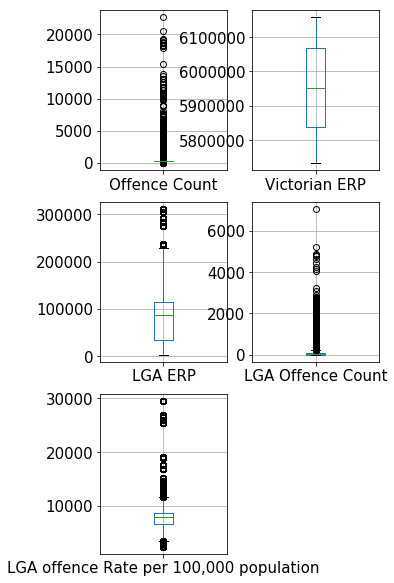

In [23]:
#boxplots are calculated for each numerical feature to obtain infrmation about outliers
plt.figure(figsize=(5,10))

plt.subplot(3,2,1)
result.boxplot(column=['Offence Count'])

plt.subplot(3,2,2)
result.boxplot(column=['Victorian ERP'])

plt.subplot(3,2,3)
result.boxplot(column=['LGA ERP'])

plt.subplot(3,2,4)
result.boxplot(column=['LGA Offence Count'])

plt.subplot(3,2,5)
result.boxplot(column=['LGA offence Rate per 100,000 population'])

#As can be seen from the boxplots below, many outliers exist within the data. This comes about as a result of the nature of 
#the dataset, given that the data is based on local government areas of varying population proportions,
#which can drastically impact the distribution of data. I believe that I should include these outliers in my analysis as they
#are an important part in determining which regions have a strong influence on the crime rate in Victoria.

,Jul - Jun reference period,LGA Offence Count,"LGA offence Rate per 100,000 population",LGA ERP,Victorian ERP
Local Government Area,,,,,
Alpine,2015.125000,2.625000,3743.306772,11954.250000,5.960936e+06
Ararat,2014.900000,7.800000,10896.211311,11080.800000,5.936754e+06
Ballarat,2014.846154,42.769231,10515.556009,101722.153846,5.933228e+06
Banyule,2015.000000,24.333333,7295.887198,126514.777778,5.949351e+06
Bass Coast,2015.000000,11.083333,8351.917815,32229.833333,5.949868e+06
Baw Baw,2014.857143,15.214286,7712.045941,46831.357143,5.934176e+06
Bayside,2014.666667,13.333333,4478.744398,100703.333333,5.913146e+06
Benalla,2014.916667,9.250000,8874.072962,13520.250000,5.939607e+06
Boroondara,2015.111111,13.444444,4328.599650,174932.888889,5.960970e+06


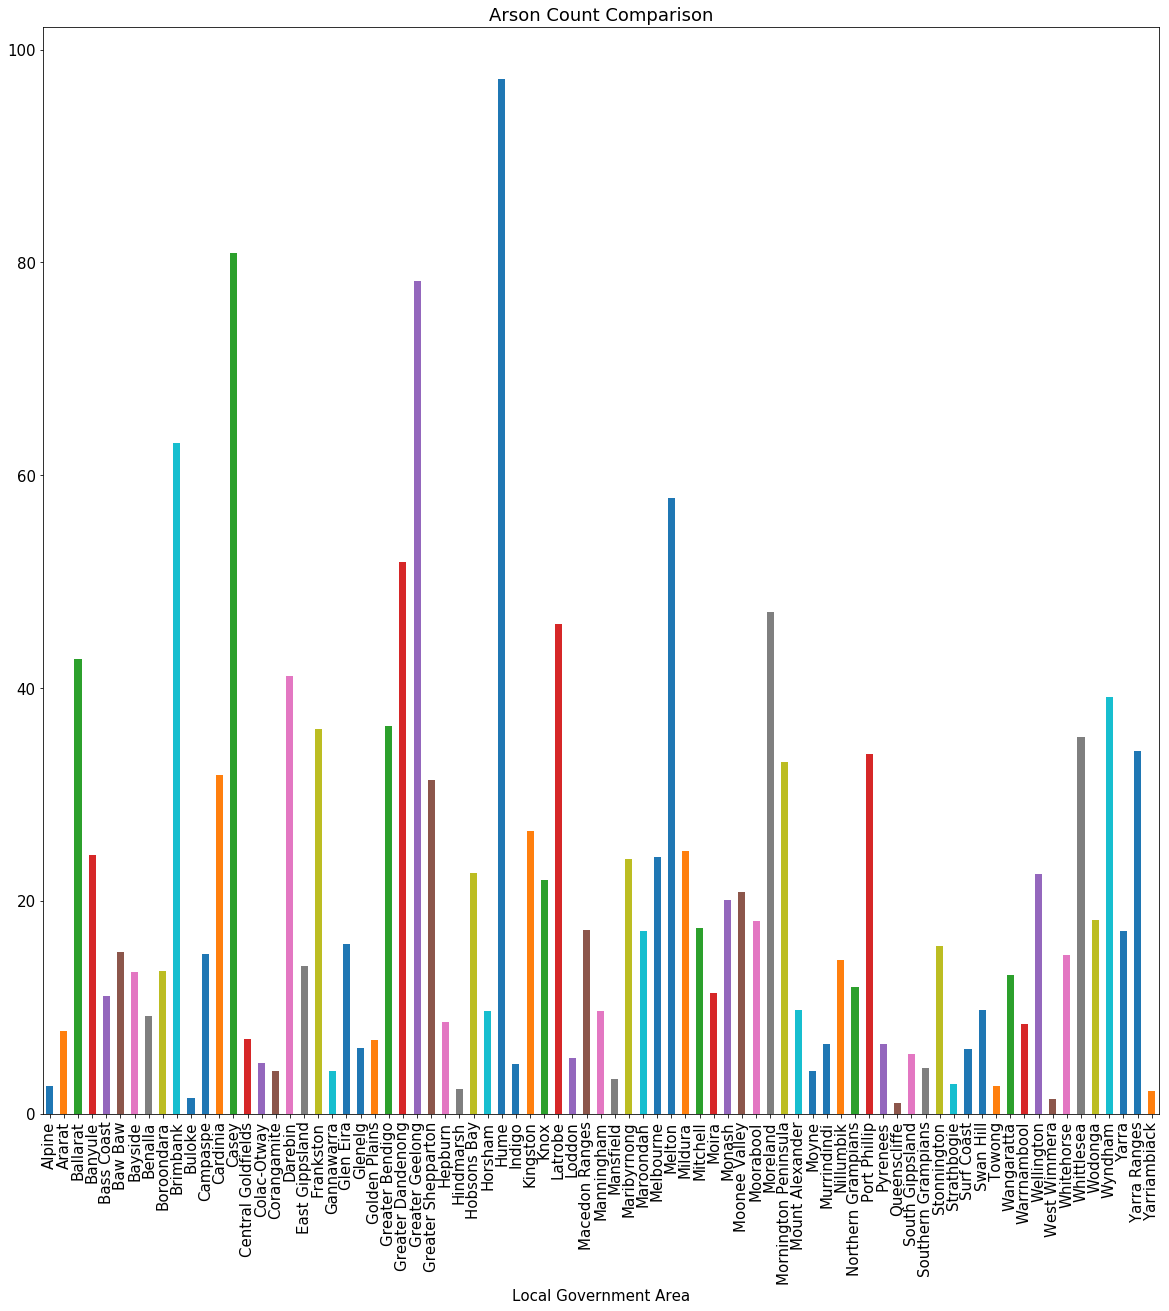

In [53]:
rate_temp = result.copy()
rate_temp = rate_temp[["Police Region","Offence Subdivision","Jul - Jun reference period","LGA Offence Count","LGA offence Rate per 100,000 population","LGA ERP","Victorian ERP","Local Government Area"]]
rate_temp = rate_temp.dropna()
rate_temp = rate_temp.drop_duplicates()
rate_temp = rate_temp.loc[rate_temp['Offence Subdivision'].str[0] == 'B']
rate_temp = rate_temp.loc[rate_temp['Offence Subdivision'].str[1] == '1']
rate_temp = rate_temp.loc[rate_temp['Offence Subdivision'].str[2] == '0']
a = rate_temp.groupby(['Local Government Area']).mean()

display(a)
a['LGA Offence Count'].plot.bar(title = "Arson Count Comparison",figsize =(20,20))

#rate_temp.head(10)

(79, 3)


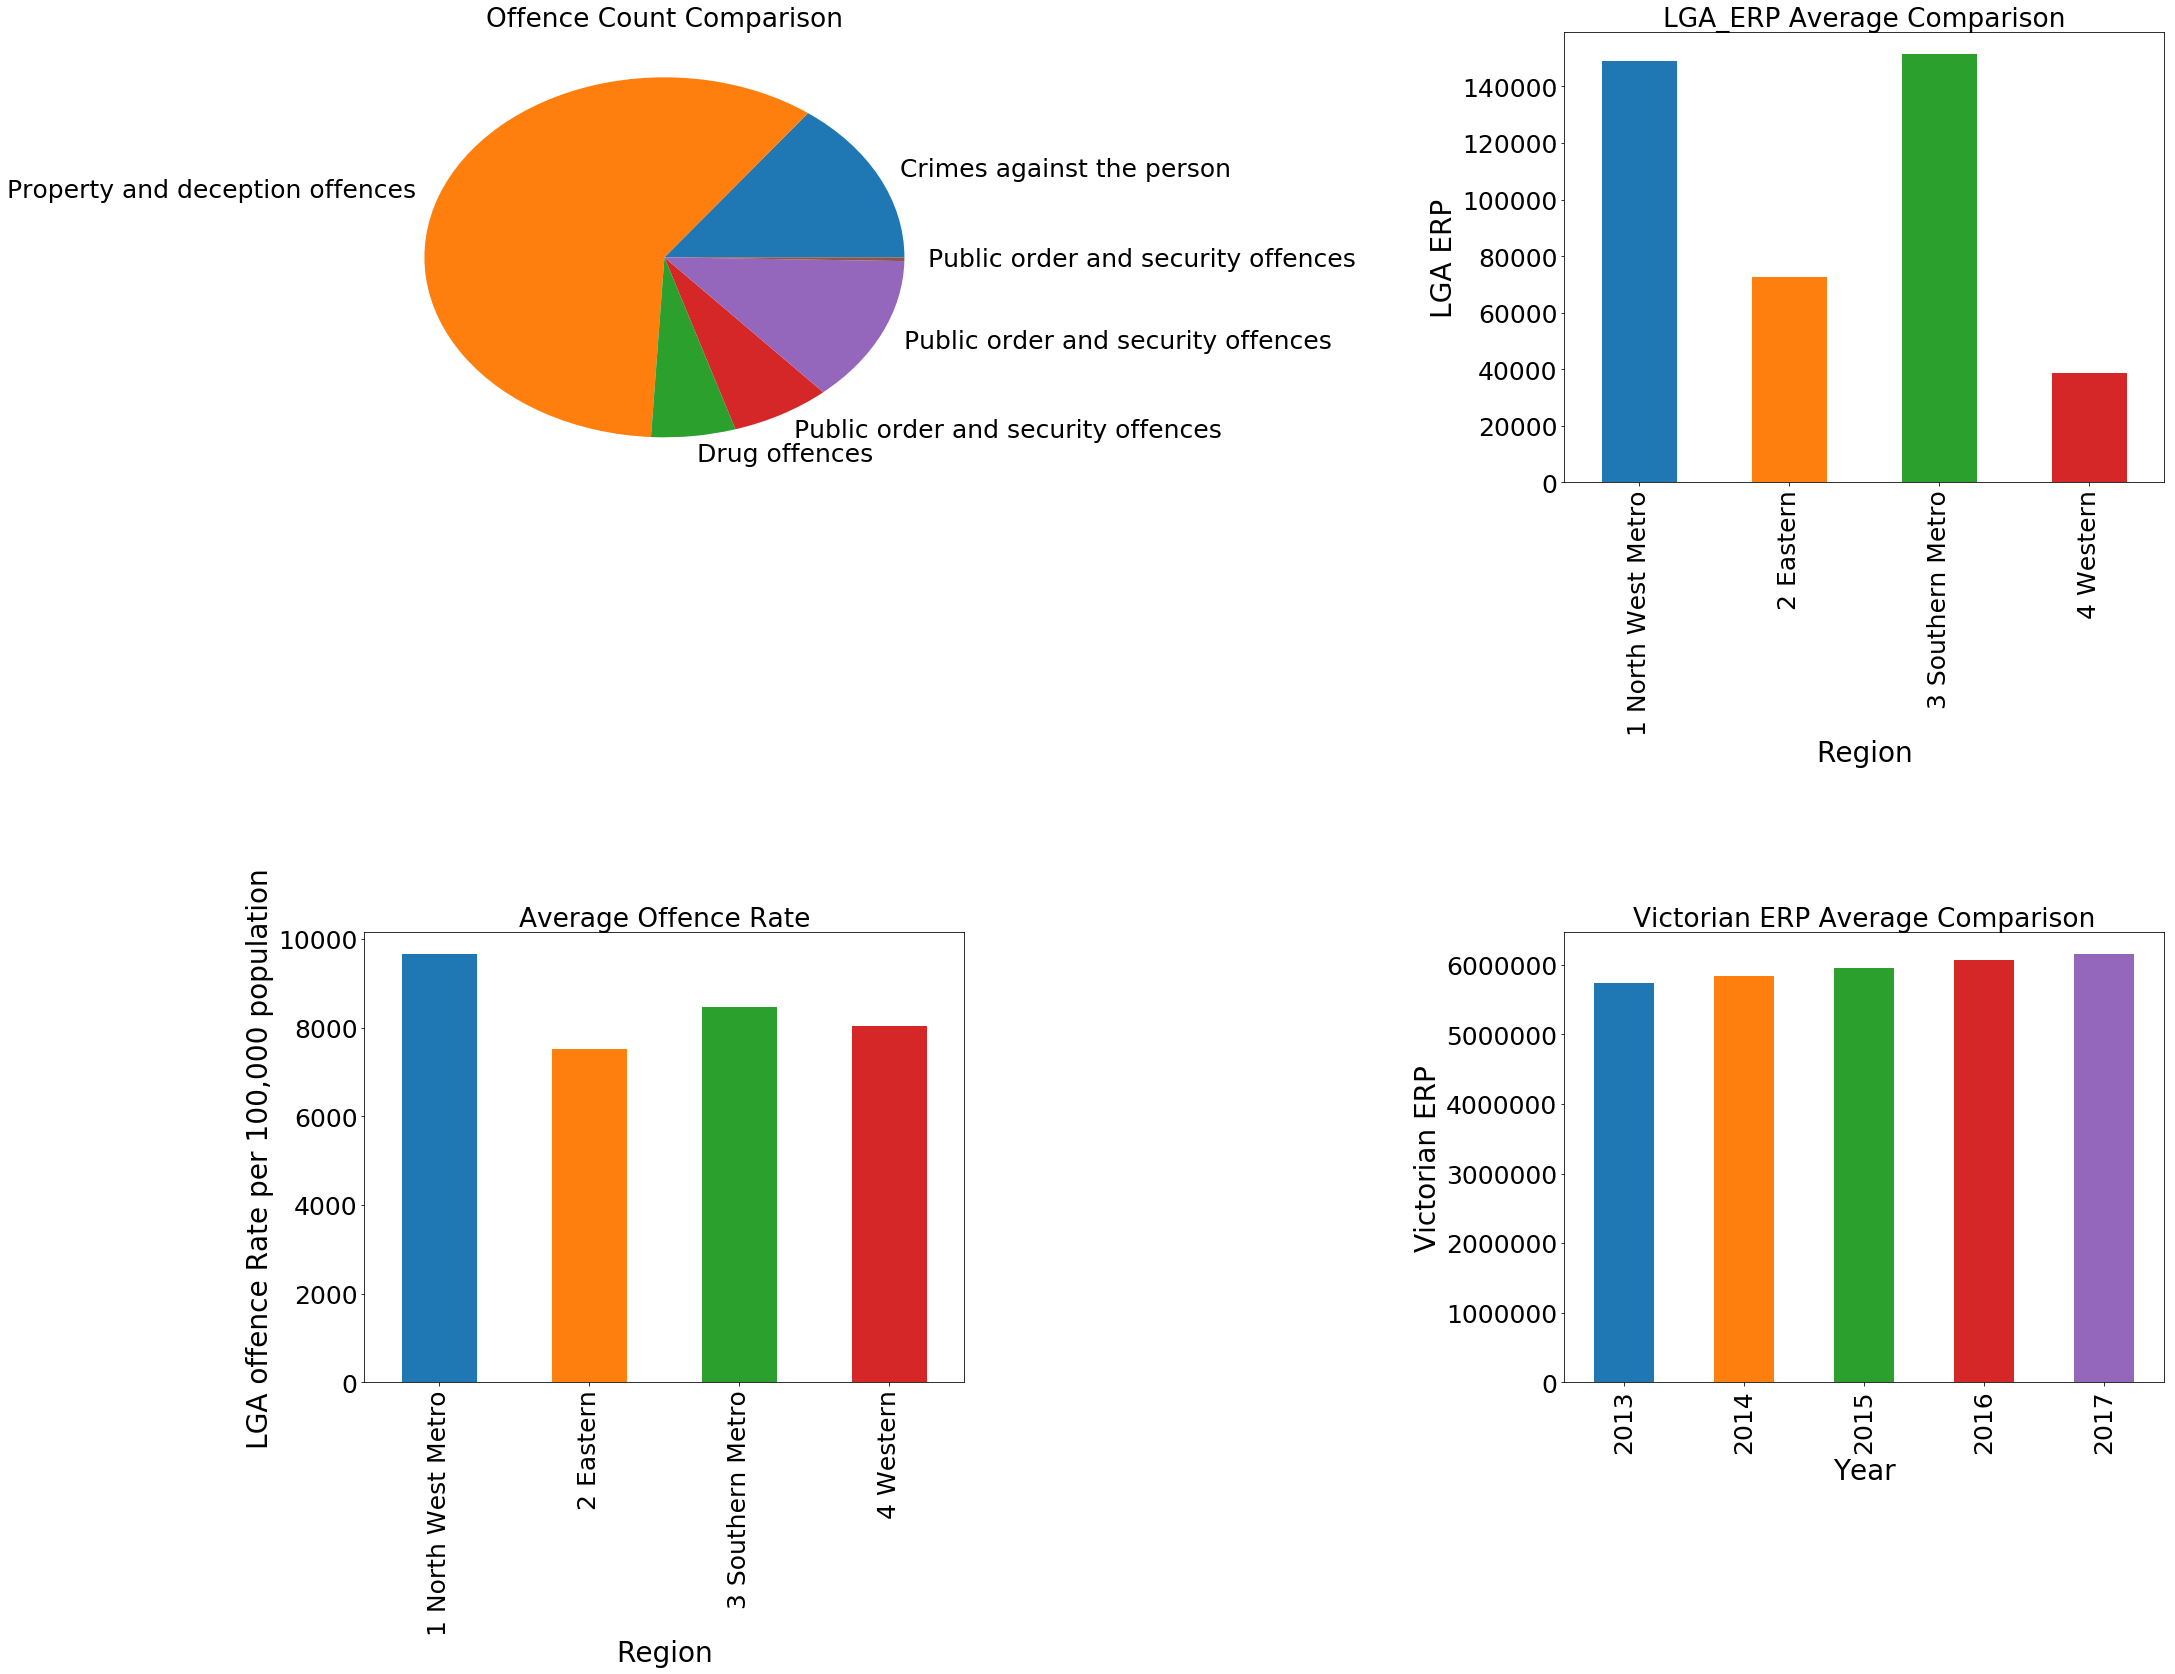

In [10]:
#these two dataframes are created to handle different columns and plot different data
plt.rcParams.update({'font.size': 22})
result_temp = result.copy()
rate_temp = result.copy()

result_temp = result_temp[["Police Region","CSA Offence Division","Jul - Jun reference period","LGA Offence Count","LGA offence Rate per 100,000 population","LGA ERP","Victorian ERP","Local Government Area"]]
rate_temp = rate_temp[["Jul - Jun reference period","Police Region","LGA offence Rate per 100,000 population"]]

#Creaes an instance of result_temp in which only data from the year 2017 is present. 
#Both dataframes drop rows with null values 
result_temp_2017 = result_temp.loc[result_temp['Jul - Jun reference period'] == 2017]
result_temp_2017 = result_temp_2017.dropna()
result_temp = result_temp.dropna()

#restricts the data of rate_temp to only include data from 2017
#drop duplicate rows which form as a result of not including the 'Local Government Area' column.
rate_temp = rate_temp.loc[rate_temp['Jul - Jun reference period'] == 2017]
rate_temp = rate_temp.dropna()
rate_temp = rate_temp.drop_duplicates()
print(rate_temp.shape)

#plots a figure
plt.figure(figsize=(5,10))

#plots a pie graph showing the porportion of types of crimes commited in 2017
plt.subplot(2,2,1)
Offence_Count_Comparison = result_temp_2017.groupby(['Jul - Jun reference period','CSA Offence Division']).sum()
Offence_Count_Comparison['LGA Offence Count'].plot.pie(title = "Offence Count Comparison",labels=['Crimes against the person','Property and deception offences','Drug offences','Public order and security offences','Public order and security offences','Public order and security offences'],fontsize=25)
plt.xlabel('', fontsize=28)
plt.ylabel('', fontsize=28)

#plots a bargraph comparing the population proportion of Victorian Regions in 2017
plt.subplot(2,2,2)
LGA_ERP_Average_Comparison = result_temp_2017.groupby(['Police Region']).mean()
LGA_ERP_Average_Comparison['LGA ERP'].plot.bar(title = "LGA_ERP Average Comparison",fontsize=25)
plt.xlabel('Region', fontsize=28)
plt.ylabel('LGA ERP', fontsize=28)


#plots a bargraph plotting the contribution of each Victorian region to criminal offences
plt.subplot(2,2,3)
Average_Offence_Rate = rate_temp.groupby(['Police Region']).mean()
Average_Offence_Rate['LGA offence Rate per 100,000 population'].plot.bar(title = "Average Offence Rate",fontsize=25)
plt.xlabel('Region', fontsize=28)
plt.ylabel('LGA offence Rate per 100,000 population', fontsize=28)

#plots a histogram showing the Estimated Resident Population over 2013-2017
plt.subplot(2,2,4)
Victorian_ERP_Average_Comparison = result_temp.groupby(['Jul - Jun reference period']).mean()
Victorian_ERP_Average_Comparison['Victorian ERP'].plot.bar(title = "Victorian ERP Average Comparison",fontsize=25)
plt.xlabel('Year', fontsize=28)
plt.ylabel('Victorian ERP', fontsize=28)

plt.subplots_adjust(left=0, bottom=None, right=5, top=2, wspace=1, hspace=1)


Analysis: The pie graph on the top left illustrates frequency of the types of crime in Victoria. As can be observed, the proportion of property related offences in comparison to other types of crime is overwhelming. This trend is very concerning and needs to be addressed. In order to investigate this issue I believe that it is important to understand the context of crime in Victoria as a whole. The top right bar chart shows the population proportion of regions when divide into regions. From this it can be observed that the smallest population proportion exists in the west and that the largest exists in North West Metro. The bottom left graph expresses the offence rate per 100,000 people. According to this chart, the Nort West Metro has the largest crime rate, followed closely by the other three regions. If a campaign was to be taken to reduce the crime rate of property offences the North West Metro region should be targeted as the highest priority in order to prevent the crime rate from spiralling out of control. Given that Western region population is relatively small, it may also be wise and efficient to deploy resources on controlling the property offence there first in order to determine an appropriate crime control strategy to apply to the bigger regions at a later date. The histogram on the bottom right illustrates the crime rate in Australia over the years and forecasts a further increase. This provides insight on the urgency to reduce the rate of crime before it is too late, which might be useful to politicians aiming to make important decisions within a short time frame.

Text(0,0.5,'LGA offence Rate per 100,000 population')

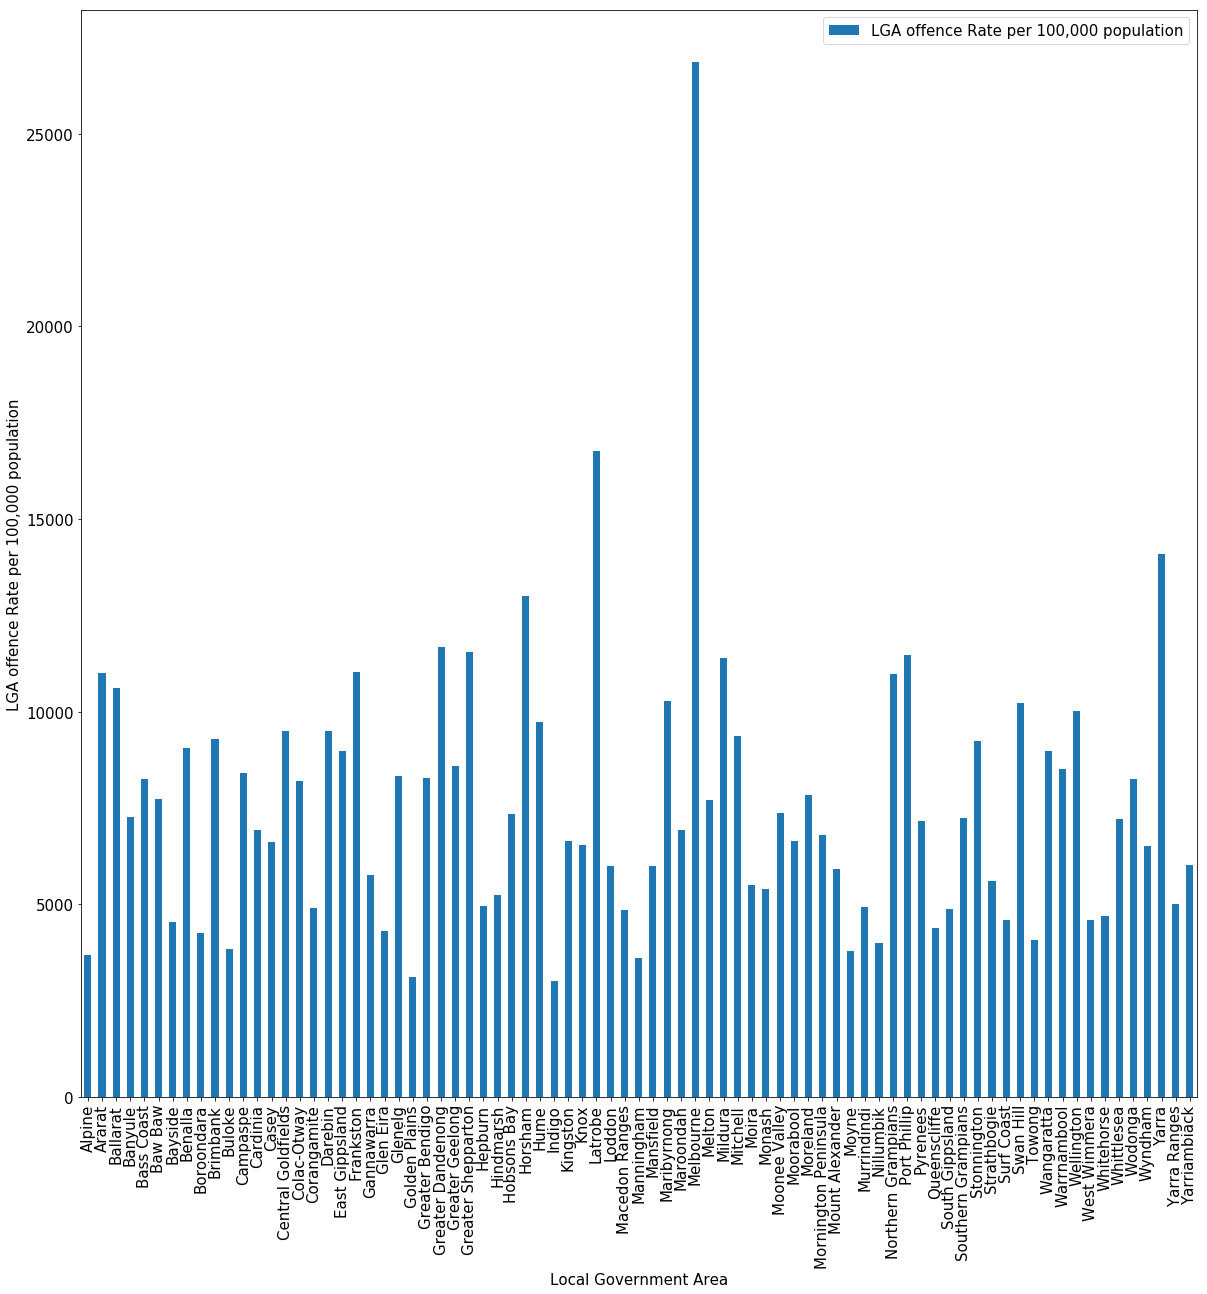

In [11]:
#graphs the offence rate of each Local Government Area in Victoria
rate_temp = result.copy()
plt.rcParams.update({'font.size': 15})
rate_temp = rate_temp[["Police Region","LGA offence Rate per 100,000 population","Local Government Area"]]
rate_temp = rate_temp.dropna()
rate_temp.head(10)
Average_Offence_Rate = rate_temp.groupby(['Local Government Area']).mean()
Average_Offence_Rate.plot.bar(figsize =(20,20))
plt.xlabel('Local Government Area', fontsize=15)
plt.ylabel('LGA offence Rate per 100,000 population', fontsize=15)


From the generated data it can be observed that Melbourne far surpasses other LGA's in terms of crime, which can be attributed to it's status as a City. This visualisations can assist policy makers in deciding what LGA to assist 

,Jul - Jun reference period,LGA Offence Count,"LGA offence Rate per 100,000 population",LGA ERP,Victorian ERP
Local Government Area,,,,,
Alpine,2017,10.571429,3224.168571,11817.0,6157538.0
Ararat,2017,25.722222,12330.025730,10884.0,6157538.0
Ballarat,2017,313.043478,11406.203920,105127.0,6157538.0
Banyule,2017,281.428571,7517.766932,128469.0,6157538.0
Bass Coast,2017,70.210526,7890.513552,33648.0,6157538.0
Baw Baw,2017,101.157895,7955.617540,48758.0,6157538.0
Bayside,2017,175.105263,4991.936029,103547.0,6157538.0
Benalla,2017,31.666667,9826.459319,13311.0,6157538.0
Boroondara,2017,290.285714,4666.651779,179122.0,6157538.0


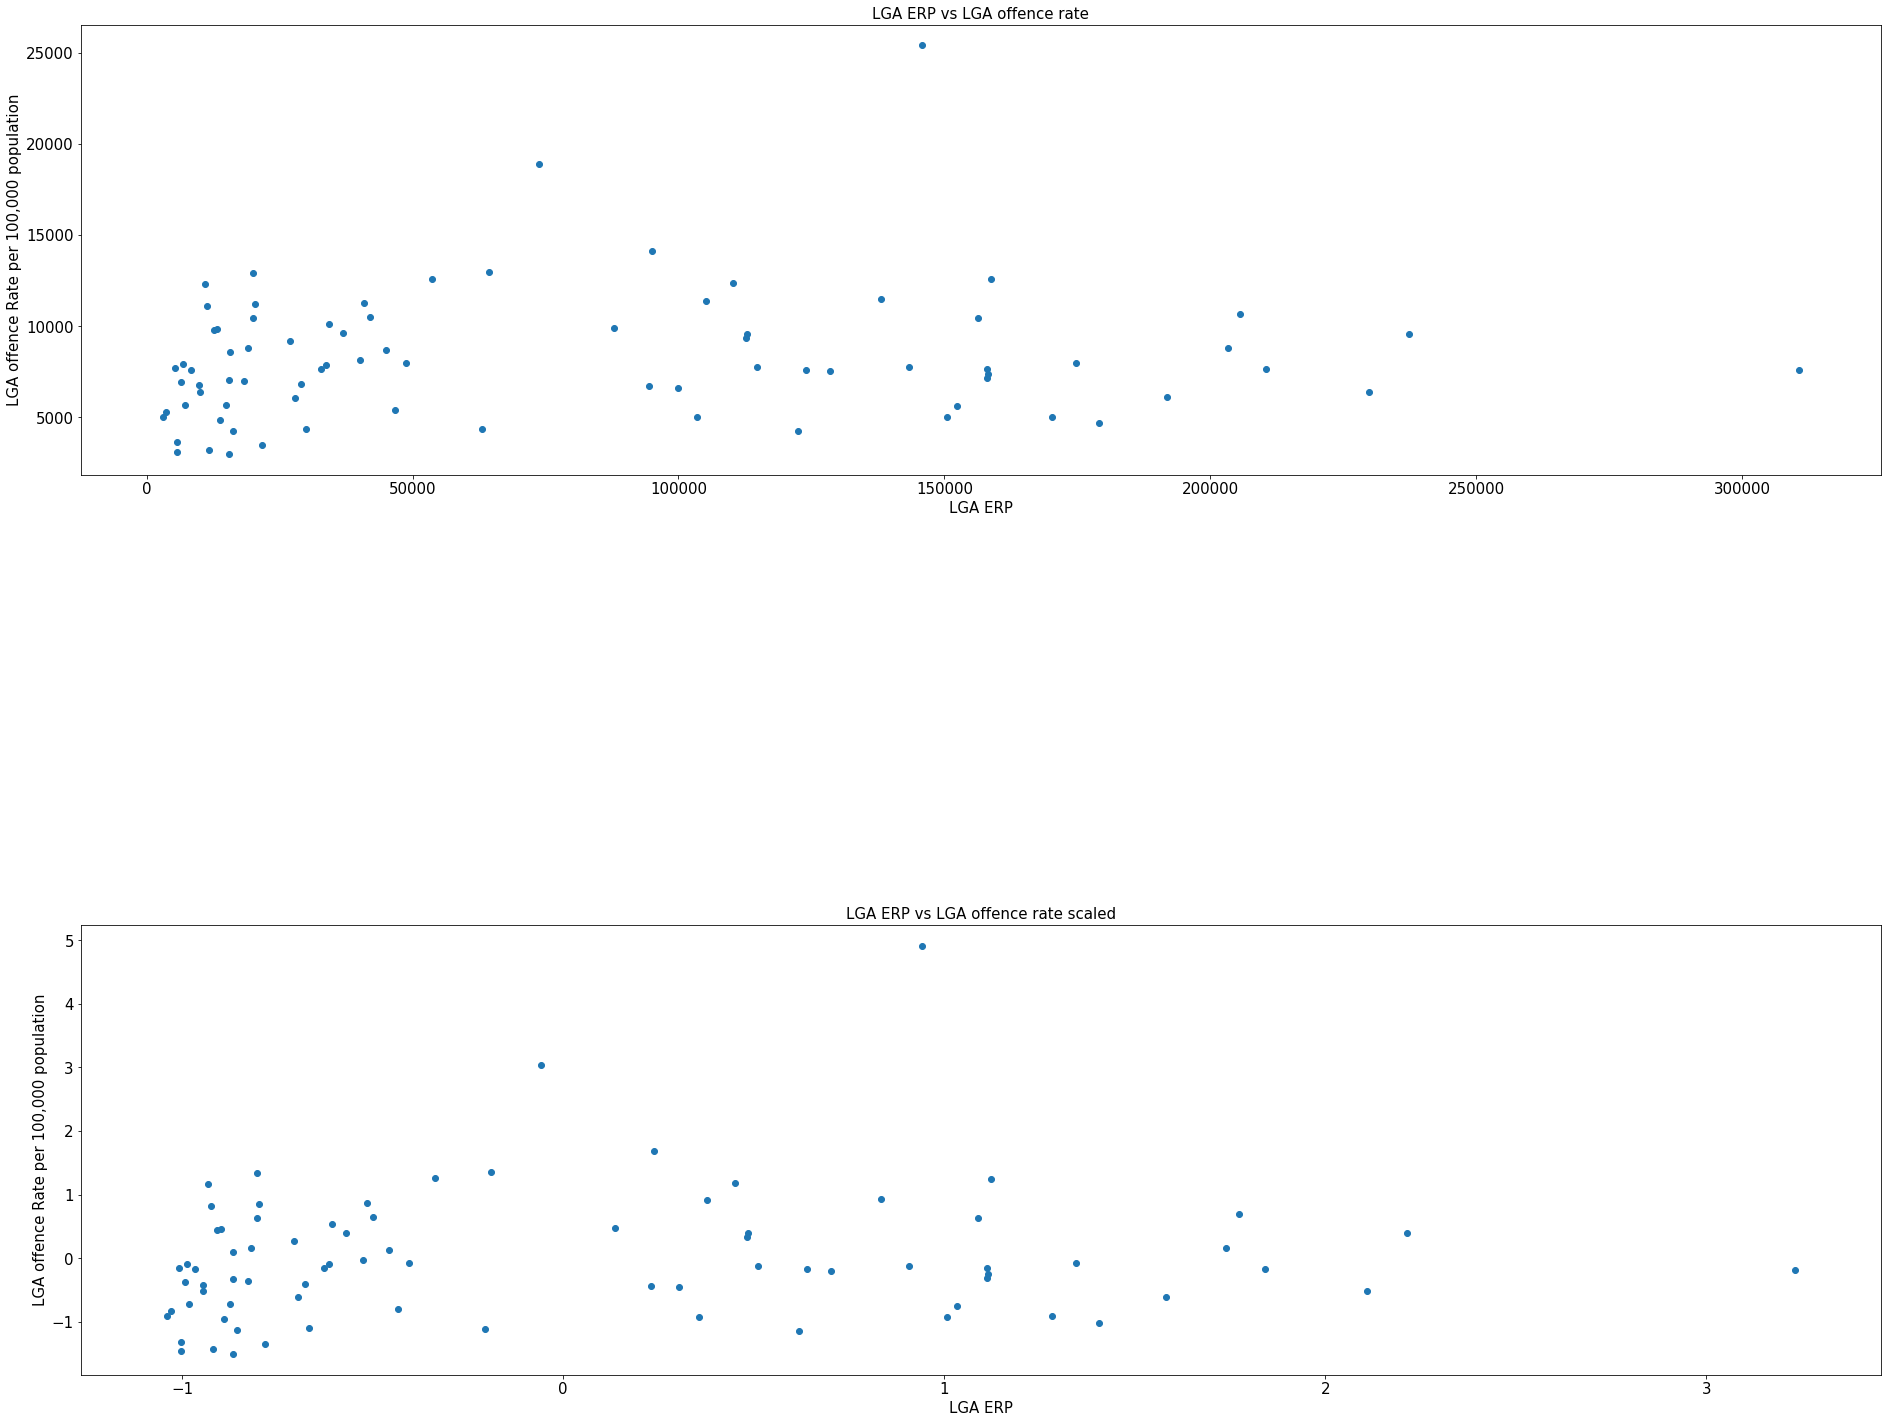

In [12]:
result_temp = result.copy()

#used to create  scaled X matrix
scaler = StandardScaler()


result_temp = result_temp[["Jul - Jun reference period","Police Region","Police Service Area","Local Government Area","CSA Offence Division","Offence Subdivision","LGA Offence Count","LGA offence Rate per 100,000 population","LGA ERP","Victorian ERP"]]
#liits the year column of the dataframe 
result_temp = result_temp.loc[result_temp['Jul - Jun reference period'] == 2017]
#filters the offence divison column to only contain property offneces
result_temp = result_temp.loc[result_temp['CSA Offence Division'].str[0] == 'B']

plt.figure(figsize=(5,10))

# drops null values
result_temp = result_temp.dropna()

#graphs LGA ERP vs LGA offence Rate for property related offences
X = result_temp.groupby(["Local Government Area"]).mean()
display(X)
plt.subplot(2,1,1)
plt.scatter(X['LGA ERP'],X['LGA offence Rate per 100,000 population'])
plt.xlabel('LGA ERP', fontsize=15)
plt.ylabel('LGA offence Rate per 100,000 population', fontsize=15)
plt.title("LGA ERP vs LGA offence rate", fontsize=15)




#graphs a scaled version of LGA ERP vs LGA offence Rate for property related offences
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

plt.subplot(2,1,2)
plt.scatter(X_scaled['LGA ERP'],X_scaled['LGA offence Rate per 100,000 population'])
plt.xlabel('LGA ERP', fontsize=15)
plt.ylabel('LGA offence Rate per 100,000 population', fontsize=15)
plt.title("LGA ERP vs LGA offence rate scaled", fontsize=15)

plt.subplots_adjust(left=0, bottom=None, right=5, top=2, wspace=1, hspace=1)


The above scatterplot allows us to illustrate the correlation between the estimated resident population for an area and it's crime rate. Fortunately, the graphs suggest a weak correlation, with the majority of LGA's having a lower criminal offence rate, except for 2 outliers. This scatterplot only contains the values of property related offences, this means that the offence rate displayed here can be applied solely to the property offences category. From this we know that generally there is no correlation suggesting that property offences are proportional to the population of an area.

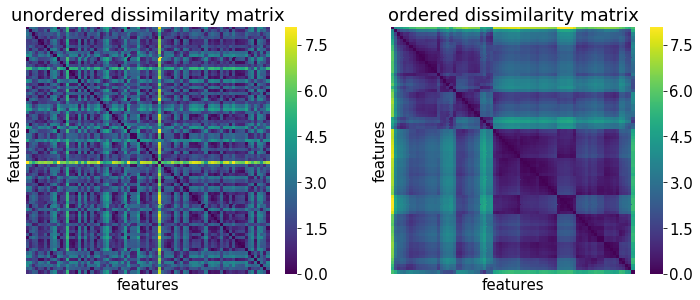

In [13]:
X_scaled_unordered=squareform(pdist(X_scaled))

#establishes plot size 
plt.figure(figsize=(12,10))

#creates a heatmap of the disimilarity matrixx
plt.subplot2grid(shape = (2,2), loc = (0,0))
heatmap=sns.heatmap(X_scaled_unordered,cmap='viridis',xticklabels=False,yticklabels=False)
heatmap.set(xlabel='features', ylabel='features')
plt.title("unordered dissimilarity matrix")

#creates a VAT heatmap
plt.subplot2grid(shape = (2,2), loc = (0,1))
X_scaled_ordered, C, I = VAT(X_scaled)
VAT=sns.heatmap(X_scaled_ordered,cmap='viridis',xticklabels=False,yticklabels=False)
VAT.set(xlabel='features', ylabel='features')
plt.title("ordered dissimilarity matrix")
plt.show()


Explanation: The above VAT heatmap and dissimilarity matrx provide an analysis of the clusters found on the above scatterplot, illustrating that there are generally two clusters on the scatterplot, as indicated by the dark areas on the ordered dissimilarity matrix.

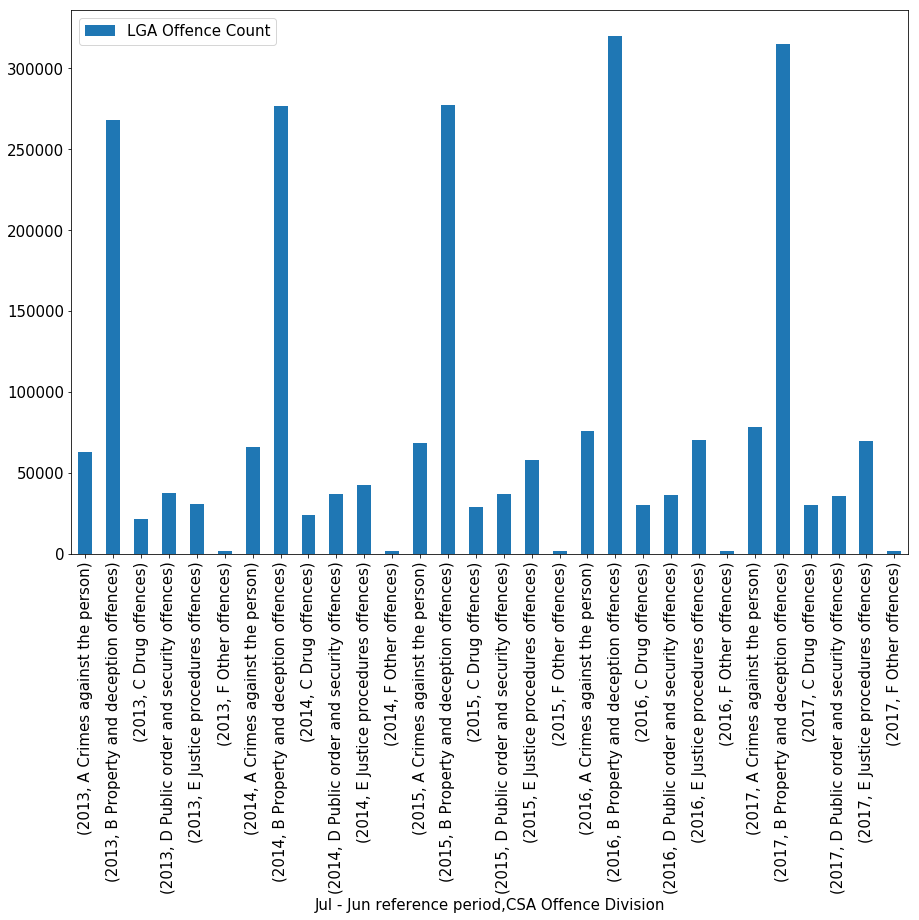

In [14]:
result_temp = result.copy()

#Creates a bargraph of the frequency of crime types over 2013-2017 by summing the count of offence types.
result_temp = result_temp[["Jul - Jun reference period","CSA Offence Division","LGA Offence Count"]]
result_temp["Jul - Jun reference period"] = result_temp["Jul - Jun reference period"]
result_temp = result_temp.dropna()
crime_type_over_years = result_temp.groupby(['Jul - Jun reference period','CSA Offence Division']).sum()
crime_type_over_years.plot.bar(figsize=(15, 10))




The above graph illustrates the overwhelming prescence of property offences over the years and is grounds to state that the investigation is tackling an important and pressing issue. From the relatively stagnant trends observed in the above bar graph.

Text(0.5,1,'normalized mutual information for binned offence counts')

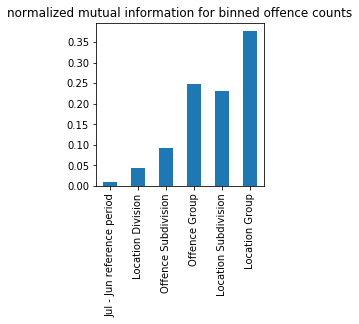

In [42]:
#In this part of the investigation we wil create 4 bins for the count of offences and use this as a class label. we will then use normalised mutual information to 
#to determine the attributes most closely associated with a certain number of offence counts  
result_temp = result.copy()
label = result.copy()

result_temp = result_temp[["Jul - Jun reference period","Location Division","Offence Subdivision","Offence Group","Location Subdivision","Location Group","Offence Count"]]
result_temp = result_temp.dropna()

#creates a dataframe to populate with normalised mutual information
graph_df = pd.DataFrame(np.random.randint(low=0, high=10, size=(1, 1)),columns=['a'])
graph_df.drop(['a'], axis=1, inplace=True)


def calc_bin(subset, num, column):
    #defines bin width
    width = (subset.values.max() - subset.values.min())/4
    #defines bin ranges
    bins = [subset.values.min(),subset.values.min()+width,subset.values.min()+(2*width)\
            ,subset.values.min()+(3*width),subset.values.max()]
    
    #prints the appropriate bins in a column
    

    #returns the appropriate bin value based on the input value
    if ((num >= bins[0]) and (num < bins[1])):
        return 1
    elif (num >= bins[1] and num < bins[2]):
        return 2
    elif (num >= bins[2] and num < bins[3]):
        return 3
    elif (num >= bins[3] and num < bins[4]):
        return 4
    #The value at the max range of the 4th bin does not get converted into a bin value
    elif (num == bins[4]):
        return num
    

for i in result_temp.index: 
    result_temp.at[i, "Offence Count"] =  calc_bin(result_temp["Offence Count"], result_temp.at[i, "Offence Count"], "Offence Count")
    
    #deactivates the bin printing capability in calc_bin
    
label = result_temp["Offence Count"]
result_temp = result_temp[["Jul - Jun reference period","Location Division","Offence Subdivision","Offence Group","Location Subdivision","Location Group"]]


for column in result_temp:
    graph_df[column] = mutual_info(result_temp[column],label)
#print(result_temp.loc[result_temp["Offence Count"] == 4])
graph_df = graph_df.transpose()

#Creates a bargraph from thee values in graph_df
graph_df.plot.bar(figsize=(3,3),legend=False)
plt.title("normalized mutual information for binned offence counts")
#result_temp.head(10)

From the above mutual information graph we were able to investigate and determine that location groups are closely linked with determining an offense count bin range. From here we can investigate location types and attempt to derive a relationship between the two attributes. Through the use of the identified mutual information it may be possible to predict future offence count trends based on decision trees and knn classifers.

Text(0.5,1,'Location Group vs offence rate')

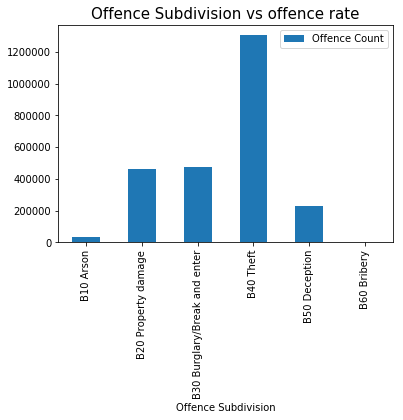

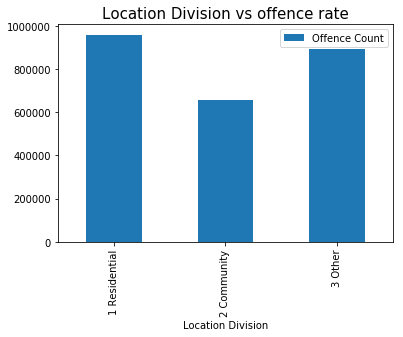

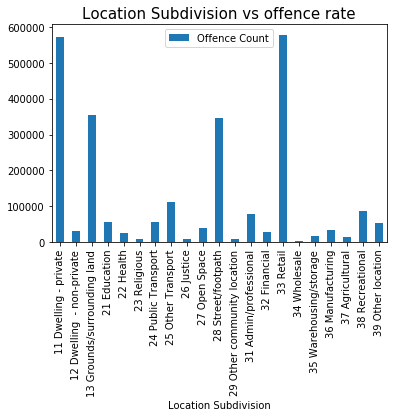

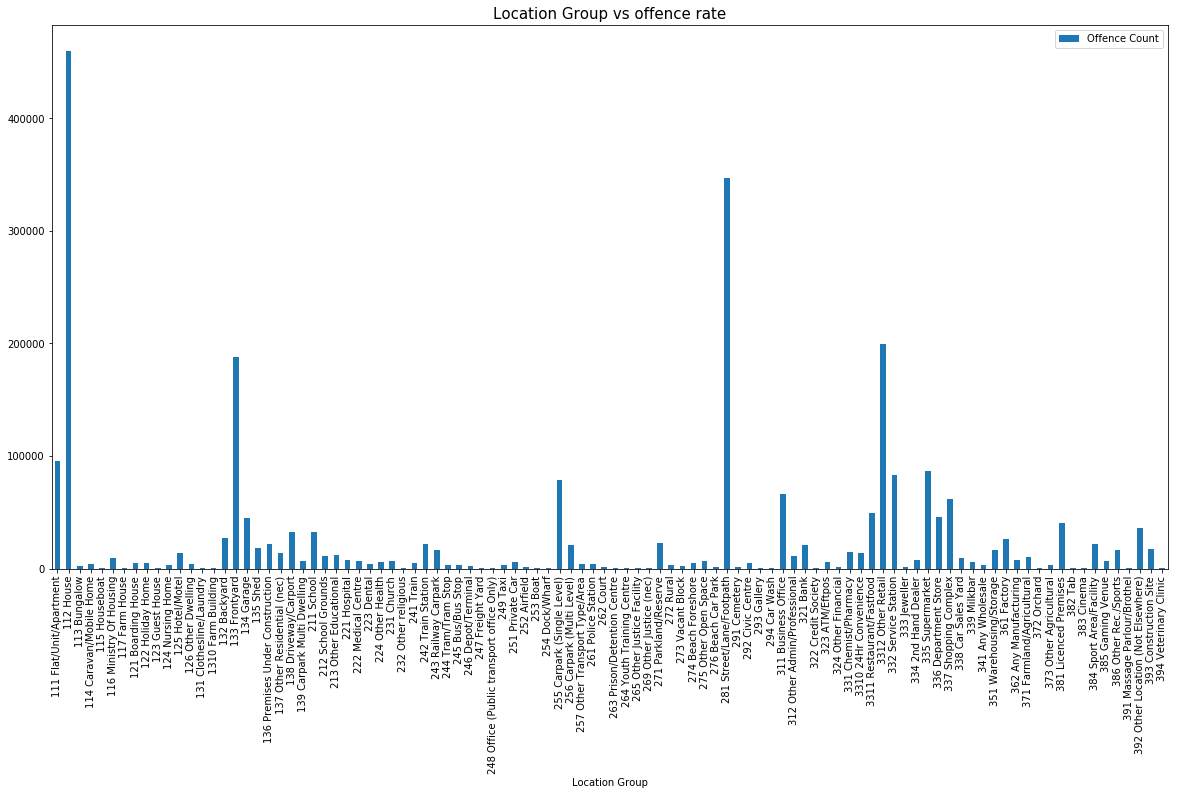

In [44]:
result_temp = result.copy()
result_temp = result_temp[["Location Division","Offence Subdivision","Offence Group","Location Subdivision","Location Group",'Offence Count']]

result_temp = result_temp.dropna()
Offence_Subdivision_grouped = result_temp.groupby(["Offence Subdivision"]).sum()
Location_Division_grouped = result_temp.groupby(["Location Division"]).sum()
Location_Subdivision_grouped = result_temp.groupby(["Location Subdivision"]).sum()
Location_Group_grouped = result_temp.groupby(["Location Group"]).sum()

Offence_Subdivision_grouped.plot.bar()
plt.title("Offence Subdivision vs offence rate", fontsize=15)


Location_Division_grouped.plot.bar()
plt.title("Location Division vs offence rate", fontsize=15)


Location_Subdivision_grouped.plot.bar()
plt.title("Location Subdivision vs offence rate", fontsize=15)


plt.rcParams.update({'font.size': 10})
Location_Group_grouped.plot.bar(figsize=(20, 10))
plt.title("Location Group vs offence rate", fontsize=15)



In [38]:
# Converts categorical features to numerical features in anticipation to creating a heatmap
X = result.copy()
X = result[["CSA Offence Division","Jul - Jun reference period","LGA Offence Count","LGA offence Rate per 100,000 population","LGA ERP","Victorian ERP","Local Government Area"]]
X = X.dropna()

X['A Crimes against the person'] = X['CSA Offence Division']
X['B Property and deception offences'] = X['CSA Offence Division']
X['C Drug offences'] = X['CSA Offence Division']
X['D Public order and security offences'] = X['CSA Offence Division']
X['E Justice procedures offences'] = X['CSA Offence Division']
X['F Other offences'] = X['CSA Offence Division']


#Iterates and assigns data to the 6 new columns based on the value of the CSA Offence Division column
for i in X.index:
   # print(X_temp.at[i, 'pay_amt1'])
    X.at[i, 'A Crimes against the person'] = 0
    X.at[i, 'B Property and deception offences'] = 0
    X.at[i, 'C Drug offences'] = 0
    X.at[i, 'D Public order and security offences'] = 0
    X.at[i, 'E Justice procedures offences'] = 0
    X.at[i, 'F Other offences'] = 0
    
    if ( X.at[i, 'CSA Offence Division'][0] == 'A'):
         X.at[i, 'A Crimes against the person'] = 1
        
        
    
    if ( X.at[i, 'CSA Offence Division'][0] == 'B'):
         X.at[i, 'B Property and deception offences'] = 1
        
        
    
    if ( X.at[i, 'CSA Offence Division'][0] == 'C'):
         X.at[i, 'C Drug offences'] = 1

    
    if ( X.at[i, 'CSA Offence Division'][0] == 'D'):
         X.at[i, 'D Public order and security offences'] = 1
        
    
    if ( X.at[i, 'CSA Offence Division'][0] == 'E'):
         X.at[i, 'E Justice procedures offences'] = 1
        
    
    if ( X.at[i, 'CSA Offence Division'][0] == 'F'):
         X.at[i, 'F Other offences'] = 1

X = X.drop(['Local Government Area'], axis=1)
X = X.drop(['CSA Offence Division'], axis=1)


X.head(5)




,Jul - Jun reference period,LGA Offence Count,"LGA offence Rate per 100,000 population",LGA ERP,Victorian ERP,A Crimes against the person,B Property and deception offences,C Drug offences,D Public order and security offences,E Justice procedures offences,F Other offences
10874,2017,2.0,7517.766932,128469.0,6157538.0,1,0,0,0,0,0
10875,2017,143.0,7517.766932,128469.0,6157538.0,1,0,0,0,0,0
10876,2017,121.0,7517.766932,128469.0,6157538.0,1,0,0,0,0,0
10877,2017,52.0,7517.766932,128469.0,6157538.0,1,0,0,0,0,0
10878,2017,196.0,7517.766932,128469.0,6157538.0,1,0,0,0,0,0


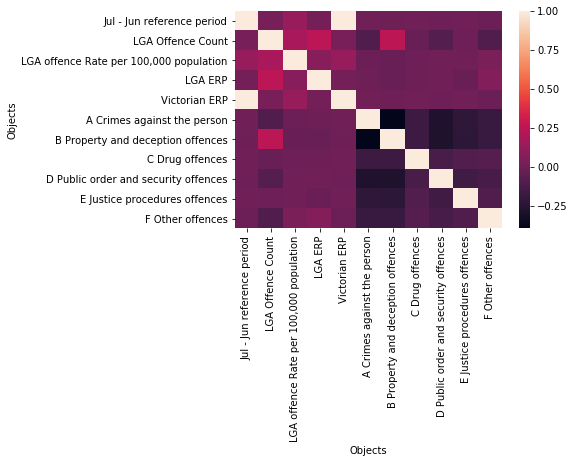

In [39]:
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
corr = X_scaled.corr()



#graphs a correlation matrix
correlation_graph=sns.heatmap(corr,xticklabels=True,yticklabels=True)
correlation_graph.set(xlabel='Objects', ylabel='Objects')
plt.show()

Continuing the investigation, we can see that the above heatmap does not show a strong correlation among attributes. The most notable feature of this heatmap can be observed through the LGA offence Count attribute which has a fair correlation with an increase in the "B property and deception offences"(most likely because this crime type appears more often than other crime types in the dataframe) and LGA ERP, though this is expected as it is natural that the crime rate will increase with an increase in population.

Conclusion: The aim of this investigation was to derive a relationship between criminal offences regarding property and the area in which such a crime would occur.  Through the use of visualisations and other analysis techniques, correlations were found between crimes and certain locales. The datasets used to find this correlation were hard to manipulate, problems mainly raised from difficulty in merging  data that was grouped by a composite key. At times the datasets needed to be treated as separate entities in order to avoid collisions with null values. I believe that my question was answered well and is supported through the investigation.